In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
xs = np.linspace(0, 1, 101)
uniform = Pmf(1, xs)

In [3]:
k, n = 140, 250
likelihood = ss.binom.pmf(k, n, xs)

In [4]:
posterior = uniform * likelihood
posterior.normalize()

0.3984063745019918

In [5]:
posterior.mean(), posterior.credible_interval(0.9)

(0.5595238095238094, array([0.51, 0.61]))

In [6]:
like_fair = ss.binom.pmf(k, n, 0.5)
like_biased = ss.binom.pmf(k, n, 0.56)

In [7]:
K = like_biased / like_fair
K

6.075990838368468

In [8]:
biased_uniform = uniform.copy()
biased_uniform[0.5] = 0
biased_uniform.normalize()
biased_uniform

,probs
0.00,0.01
0.01,0.01
0.02,0.01
0.03,0.01
0.04,0.01
...,...
0.96,0.01
0.97,0.01
0.98,0.01
0.99,0.01


In [9]:
xs = biased_uniform.qs
likelihood = ss.binom.pmf(k, n, xs)

In [10]:
like_uniform = np.sum(biased_uniform * likelihood)

In [11]:
K = like_uniform / like_fair
K

0.4667233591607596

In [12]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)
a = np.append(ramp_up, ramp_down)

In [13]:
triangle = Pmf(a, xs, name='triangle')
triangle.normalize()

2500

In [14]:
biased_triangle = triangle.copy()
biased_triangle[0.5] = 0
biased_triangle.normalize()
biased_triangle

,probs
0.00,0.000000
0.01,0.000408
0.02,0.000816
0.03,0.001224
0.04,0.001633
...,...
0.96,0.001633
0.97,0.001224
0.98,0.000816
0.99,0.000408


In [15]:
xs = biased_triangle.qs
likelihood = ss.binom.pmf(k, n, xs)

In [16]:
like_triangle = np.sum(biased_triangle * likelihood)

In [17]:
K = like_triangle / like_fair
K

0.8353683926774023

In [18]:
xs = np.linspace(0, 1, 101)
prior = Pmf(1, xs)
prior.normalize()

101

In [19]:
beliefs = [prior.copy() for i in range(4)]

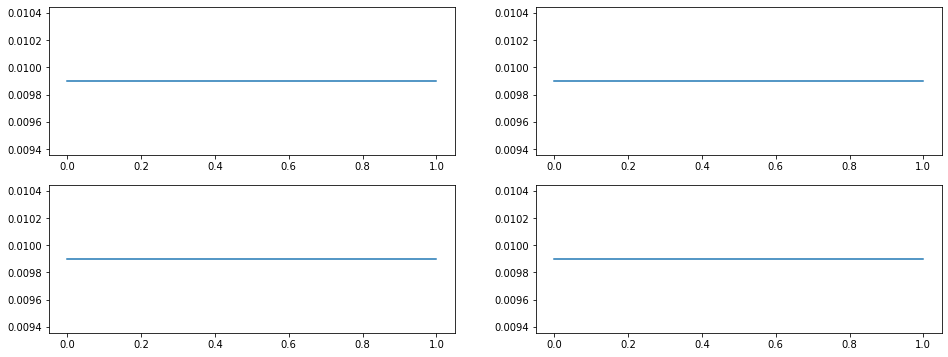

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(16, 6))
for belief, ax in zip(beliefs, axs.ravel()):
    ax.plot(belief)

In [21]:
likelihood = {'W': xs, 'L': 1 - xs}

In [22]:
def update(pmf, data):
    pmf *= likelihood[data]
    pmf.normalize()

In [23]:
bandit = prior.copy()
for outcome in 'WLLLLLLLLL':
    update(bandit, outcome)

In [24]:
actual_probs = [0.1, 0.2, 0.3, 0.4]

In [25]:
counter = Counter()

def play(i):
    counter[i] += 1
    p = actual_probs[i]
    if np.random.random() < p:
        return 'W'
    else:
        return 'L'

In [26]:
for i in range(4):
    for _ in range(10):
        outcome = play(i)
        update(beliefs[i], outcome)

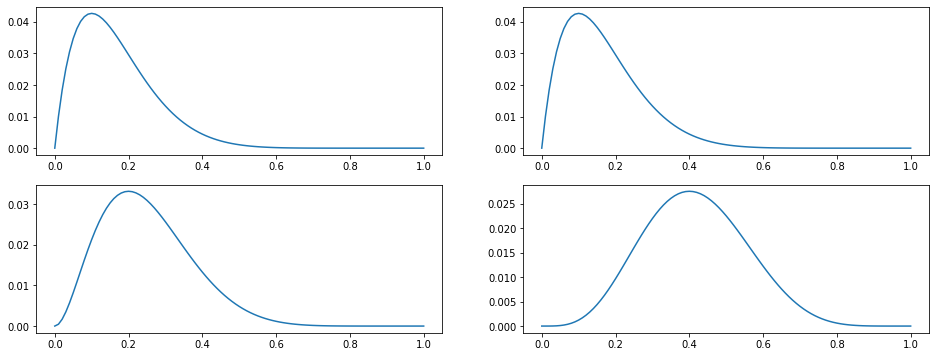

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(16, 6))
for belief, ax in zip(beliefs, axs.ravel()):
    ax.plot(belief)

In [28]:
[belief.credible_interval(0.9) for belief in beliefs]

[array([0.03, 0.36]),
 array([0.03, 0.36]),
 array([0.08, 0.47]),
 array([0.2 , 0.65])]

In [29]:
samples = np.array([b.choice(1000) for b in beliefs])
samples

array([[0.23, 0.09, 0.1 , ..., 0.21, 0.18, 0.05],
       [0.09, 0.29, 0.05, ..., 0.06, 0.17, 0.14],
       [0.21, 0.21, 0.07, ..., 0.08, 0.13, 0.13],
       [0.25, 0.44, 0.4 , ..., 0.34, 0.24, 0.32]])

In [30]:
indices = np.argmax(samples, axis=0)

In [31]:
pmf = Pmf.from_seq(indices)
pmf

,probs
0,0.045
1,0.054
2,0.140
3,0.761


In [32]:
pmf.choice()

3

In [33]:
def choose(beliefs):
    ps = [b.choice() for b in beliefs]
    return np.argmax(ps)

In [34]:
choose(beliefs)

3

In [35]:
def choose_play_update(beliefs):
    machine = choose(beliefs)
    outcome = play(machine)
    update(beliefs[machine], outcome)

In [36]:
beliefs = [prior.copy() for i in range(4)]
counter = Counter()

In [37]:
num_plays = 300
for i in range(num_plays):
    choose_play_update(beliefs)

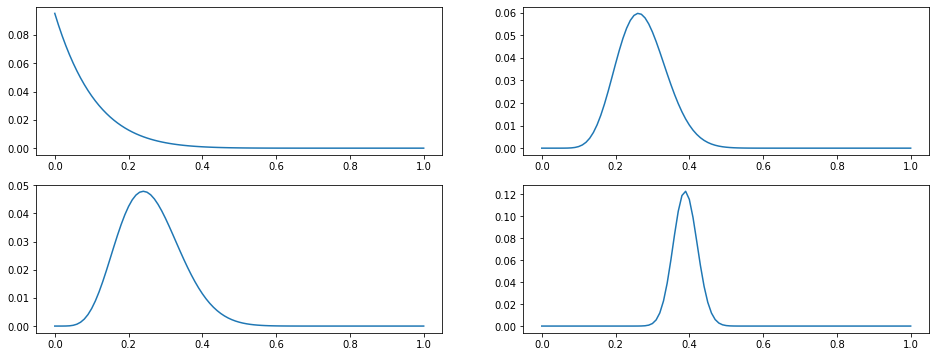

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(16, 6))
for belief, ax in zip(beliefs, axs.ravel()):
    ax.plot(belief)

In [39]:
[b.credible_interval(0.9) for b in beliefs]

[array([0.  , 0.26]),
 array([0.17, 0.39]),
 array([0.13, 0.41]),
 array([0.34, 0.44])]

In [40]:
counter

Counter({0: 9, 3: 224, 1: 42, 2: 25})